<a href="https://colab.research.google.com/github/MesquitaALucas/Scketchbook/blob/main/TP2_ICV_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/amandaxm/icv-reconhecimento-captcha

fatal: destination path 'icv-reconhecimento-captcha' already exists and is not an empty directory.


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm

from skimage.feature import hog

from sklearn.metrics import classification_report,accuracy_score

from PIL import ImageFilter

from sklearn.ensemble import RandomForestClassifier

np.random.seed(123)  # for reproducibility

In [ ]:
path_labels = 'icv-reconhecimento-captcha/labels10k/'
path_train = 'icv-reconhecimento-captcha/treinamento/'
path_validation = 'icv-reconhecimento-captcha/validacao/'
path_test = 'icv-reconhecimento-captcha/teste/'

In [ ]:
def get_images(path):
  images = dict()
  for filename in os.listdir(path):
    images[filename.split('.')[0]] = Image.open(path + '/' + filename)
  return images

In [ ]:
images_train = get_images(path_train)
images_validation = get_images(path_validation)
images_test = get_images(path_test)

In [ ]:
labels = dict()
for filename in os.listdir(path_labels):
  with open(path_labels + '/' + filename) as f: label = f.read().replace('\n', '')
  labels[filename.split('.')[0]] = label

In [ ]:
df_train = pd.DataFrame(images_train.items(), columns=['File', 'Image'])

In [ ]:
df_validation = pd.DataFrame(images_validation.items(), columns=['File', 'Image'])

In [ ]:
df_test = pd.DataFrame(images_test.items(), columns=['File', 'Image'])

In [ ]:
df_dict = {
    'train': df_train,
    'validation': df_validation,
    'test': df_test,
}

In [ ]:
df = pd.concat([df.assign(Subset=k) for k,df in df_dict.items()]).sort_values('File')

In [ ]:
df

,File,Image,Subset
6917,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
4955,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
1991,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
1705,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
82,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
...,...,...,...
184,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
297,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
25,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
380,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test


In [ ]:
df_labels = pd.DataFrame(labels.items(), columns=['File', 'Label'])

In [ ]:
df_labels

,File,Label
0,009237,49YIRU
1,009976,AOUAYT
2,004307,JD1C1C
3,002988,EVNJJX
4,006869,93WDFT
...,...,...
9995,004061,DEVN4B
9996,004038,M3U9W8
9997,001594,GBUJU8
9998,002517,8NUXEI


In [ ]:
df = pd.merge(df, df_labels, on='File')

In [ ]:
df

,File,Image,Subset,Label
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA
...,...,...,...,...
9995,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,66ZDPA
9996,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,2044B3
9997,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,SNB9SO
9998,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,0DTW1D


In [ ]:
not_len_6_df = df[df['Label'].str.len() != 6]

In [ ]:
contains_question_df = df[df['Label'].str.contains('\?') == True]

In [ ]:
not_len_6_df['Subset'].value_counts()

,count
Subset,
train,3
validation,1
test,1


In [ ]:
contains_question_df['Subset'].value_counts()

,count
Subset,
train,98


In [ ]:
df = df[df['Label'].str.contains('\?') == False]
df = df[df['Label'].str.len() == 6]

In [ ]:
df['Image_Gaussian'] = df['Image'].apply(lambda image: image.filter(ImageFilter.GaussianBlur(1)))
df['Image_Median'] = df['Image'].apply(lambda image: image.filter(ImageFilter.MedianFilter))
df['Image_Max'] = df['Image'].apply(lambda image: image.filter(ImageFilter.MaxFilter))

In [ ]:
df['Image_array_1'] = df['Image_Gaussian'].apply(lambda image: (np.asarray(image) > 128).astype(int)[:, 12:, 0])
df['Image_array_2'] = df['Image_array_3'] = df['Image_array_4'] = df['Image_array_5'] = df['Image_array_6'] = df['Image_array_1']

In [ ]:
# df['Image_array_1'] = df['Image'].apply(lambda image: np.asarray(image).astype(float)[:, 12:, 0]/255)
# df['Image_array_2'] = df['Image_array_3'] = df['Image_array_4'] = df['Image_array_5'] = df['Image_array_6'] = df['Image_array_1']

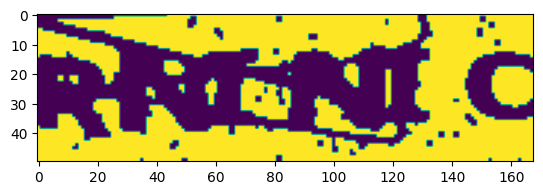

In [ ]:
plt.imshow(df['Image_array_1'][0])

In [ ]:
for i in range(6):
  df[f'Image_array_{i+1}'] = df[f'Image_array_{i+1}'].apply(lambda array: array[:, 28*i:28*i+28])

In [ ]:
labels_to_int = dict()

In [ ]:
for i in range(10):
  labels_to_int[str(i)] = i

for i in range(26):
  labels_to_int[chr(ord('A') + i)] = 10 + i

In [ ]:
df['Label_int_1'] = df['Label'].apply(lambda label: [*label]).apply(lambda l: np.array(list(map(labels_to_int.get, l))))
df['Label_int_2'] = df['Label_int_3'] = df['Label_int_4'] = df['Label_int_5'] = df['Label_int_6'] = df['Label_int_1']

In [ ]:
for i in range(6):
  df[f'Label_int_{i+1}'] = df[f'Label_int_{i+1}'].apply(lambda l: l[i])

In [ ]:
df.head()

,File,Image,Subset,Label,Image_Gaussian,Image_Median,Image_Max,Image_array_1,Image_array_2,Image_array_3,Image_array_4,Image_array_5,Image_array_6,Label_int_1,Label_int_2,Label_int_3,Label_int_4,Label_int_5,Label_int_6
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",27,23,18,23,18,12
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",29,31,12,15,28,8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,"[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",23,1,24,1,14,17
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",24,26,35,28,21,4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,<PIL.Image.Image image mode=RGB size=180x50 at...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",16,28,29,2,34,10


In [ ]:
X_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Image_array_{i+1}'])) for i in range(6)])
X_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Image_array_{i+1}'])) for i in range(6)])
X_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Image_array_{i+1}'])) for i in range(6)])
Y_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Label_int_{i+1}'])) for i in range(6)])
Y_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Label_int_{i+1}'])) for i in range(6)])
Y_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Label_int_{i+1}'])) for i in range(6)])

In [ ]:
X_train_left = X_train[0]
X_train_center = X_train[1:-1]
X_train_right = X_train[-1]

X_test_left = X_test[0]
X_test_center = X_test[1:-1]
X_test_right = X_test[-1]

X_validation_left = X_validation[0]
X_validation_center = X_validation[1:-1]
X_validation_right = X_validation[-1]

Y_train_left = Y_train[0]
Y_train_center = Y_train[1:-1]
Y_train_right = Y_train[-1]

Y_test_left = Y_test[0]
Y_test_center = Y_test[1:-1]
Y_test_right = Y_test[-1]

Y_validation_left = Y_validation[0]
Y_validation_center = Y_validation[1:-1]
Y_validation_right = Y_validation[-1]

In [ ]:
a, b, c, d = X_train_center.shape
X_train_center = X_train_center.reshape((a*b, c, d))
a, b, c, d = X_test_center.shape
X_test_center = X_test_center.reshape((a*b, c, d))
a, b, c, d = X_validation_center.shape
X_validation_center = X_validation_center.reshape((a*b, c, d))
a, b = Y_train_center.shape
Y_train_center = Y_train_center.reshape((a*b))
a, b = Y_test_center.shape
Y_test_center = Y_test_center.reshape((a*b))
a, b = Y_validation_center.shape
Y_validation_center = Y_validation_center.reshape((a*b))

In [ ]:
category_count = len(labels_to_int)

Y_train_left_categorical = to_categorical(Y_train_left, category_count)
Y_train_center_categorical = to_categorical(Y_train_center, category_count)
Y_train_right_categorical = to_categorical(Y_train_right, category_count)

Y_test_left_categorical = to_categorical(Y_test_left, category_count)
Y_test_center_categorical = to_categorical(Y_test_center, category_count)
Y_test_right_categorical = to_categorical(Y_test_right, category_count)

Y_validation_left_categorical = to_categorical(Y_validation_left, category_count)
Y_validation_center_categorical = to_categorical(Y_validation_center, category_count)
Y_validation_right_categorical = to_categorical(Y_validation_right, category_count)

## Histograma

In [ ]:
l = np.array(list(df['Image'].apply(lambda image: (np.asarray(image) > 128).astype(int)[:, :, 0])))

In [ ]:
l.shape

(9897, 50, 180)

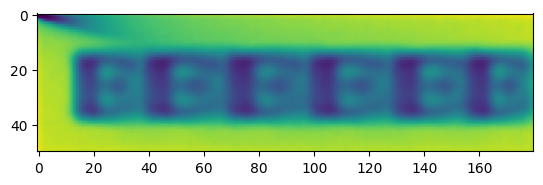

In [ ]:
plt.imshow(l.sum(axis = 0))

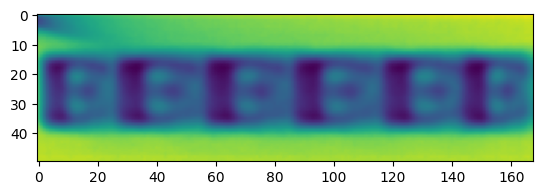

In [ ]:
plt.imshow(l.sum(axis = 0)[:, 12:])

# Convolucional

## Left

In [ ]:
# Sequential layer
model_left = Sequential()

# CNN input layer
model_left.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

# hiden layers
model_left.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_left.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_left.add(Dropout(0.25))

# fully connected layer
model_left.add(Flatten())
model_left.add(Dense(32, activation='relu'))
model_left.add(Dropout(0.5))
model_left.add(Dense(category_count, activation='softmax'))

model_left.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_left.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model_left.fit(X_train_left, Y_train_left_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.0549 - loss: 3.5172
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 490ms/step - accuracy: 0.1374 - loss: 3.0615
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.1981 - loss: 2.7340
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - accuracy: 0.2400 - loss: 2.4886
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.2721 - loss: 2.3481


In [ ]:
score = model_left.evaluate(X_validation_left, Y_validation_left_categorical, verbose=1)
print(score)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6990 - loss: 1.4719
[1.4709218740463257, 0.6916916966438293]


## Center

In [ ]:
# Sequential layer
model_center = Sequential()

# CNN input layer
model_center.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

# hiden layers
model_center.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_center.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_center.add(Dropout(0.25))

# fully connected layer
model_center.add(Flatten())
model_center.add(Dense(32, activation='relu'))
model_center.add(Dropout(0.5))
model_center.add(Dense(category_count, activation='softmax'))

model_center.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_center.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model_center.fit(X_train_center, Y_train_center_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 115s 458ms/step - accuracy: 0.1083 - loss: 3.2448
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 114s 460ms/step - accuracy: 0.3292 - loss: 2.1449
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 143s 465ms/step - accuracy: 0.3888 - loss: 1.8605
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 111s 451ms/step - accuracy: 0.4483 - loss: 1.6588
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 143s 456ms/step - accuracy: 0.4952 - loss: 1.5077


In [ ]:
score = model_center.evaluate(X_validation_center, Y_validation_center_categorical, verbose=1)
print(score)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8148 - loss: 0.6682
[0.7205666899681091, 0.7967967987060547]


## Right

In [ ]:
# Sequential layer
model_right = Sequential()

# CNN input layer
model_right.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

# hiden layers
model_right.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_right.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_right.add(Dropout(0.25))

# fully connected layer
model_right.add(Flatten())
model_right.add(Dense(32, activation='relu'))
model_right.add(Dropout(0.5))
model_right.add(Dense(category_count, activation='softmax'))

model_right.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_right.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model_right.fit(X_train_right, Y_train_right_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 490ms/step - accuracy: 0.0595 - loss: 3.4774
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 450ms/step - accuracy: 0.1399 - loss: 3.0430
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 483ms/step - accuracy: 0.1967 - loss: 2.7499
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 444ms/step - accuracy: 0.2429 - loss: 2.5562
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.2635 - loss: 2.4098


In [ ]:
score = model_right.evaluate(X_validation_right, Y_validation_right_categorical, verbose=1)
print(score)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6133 - loss: 1.5900
[1.5813186168670654, 0.6236236095428467]


## Consolidate

In [ ]:
model_center.predict(X_test_center).shape

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


(3996, 36)

In [ ]:
Y_test_categorical = to_categorical(Y_test, category_count)

In [ ]:
model_left_test_prediction = model_left.predict(X_test_left)
model_center_test_prediction = model_center.predict(X_test_center)
model_right_test_prediction = model_right.predict(X_test_left)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


In [ ]:
a, b = model_center_test_prediction.shape
model_center_test_prediction = model_center_test_prediction.reshape((4, a//4, b))

test_prediction = np.zeros((6, a//4, b))
test_prediction[0] = model_left_test_prediction
test_prediction[1:-1] = model_center_test_prediction
test_prediction[-1] = model_right_test_prediction

In [ ]:
test_prediction.argmax(axis = 2)

array([[19, 17,  1, ..., 28,  0, 12],
       [31,  2, 14, ..., 23, 13,  9],
       [ 4,  7, 15, ..., 11, 29,  2],
       [12, 30,  8, ...,  0, 32,  1],
       [ 2, 12, 32, ..., 28, 35,  2],
       [30, 17, 18, ..., 28,  0, 24]])

In [ ]:
Y_test

array([[19, 17,  1, ..., 28,  0, 12],
       [32,  2, 14, ..., 23, 13,  9],
       [ 4,  7, 15, ..., 11, 29,  2],
       [12, 21,  8, ...,  9, 32,  1],
       [35, 12, 32, ..., 28,  1, 35],
       [15, 22,  0, ..., 24, 13, 30]])

In [ ]:
total = np.size(Y_test)

In [ ]:
acertos = np.sum(test_prediction.argmax(axis = 2) == Y_test)

In [ ]:
acertos/total

0.6471471471471472

# HOG

In [ ]:
for i in range(6):
  i = i + 1
  fds = list()
  hog_images = list()
  for image in df[f'Image_array_{i}']:
    fd, hog_image = hog(
      image,
      orientations=8,
      pixels_per_cell=(10, 9),
      cells_per_block=(1, 1),
      visualize=True,
    )
    fds.append(fd)
    hog_images.append(hog_image)
  df[f'fd_{i}'] = fds
  df[f'hog_image_{i}'] = hog_images

In [ ]:
fd_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'fd_{i+1}'])) for i in range(6)])
fd_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'fd_{i+1}'])) for i in range(6)])
fd_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'fd_{i+1}'])) for i in range(6)])

In [ ]:
fd_train_left = fd_train[0]
fd_test_left = fd_test[0]
fd_validation_left = fd_validation[0]

fd_train_center = fd_train[1:-1]
fd_test_center = fd_test[1:-1]
fd_validation_center = fd_validation[1:-1]

fd_train_right = fd_train[-1]
fd_test_right = fd_test[-1]
fd_validation_right = fd_validation[-1]

a, b, c = fd_train_center.shape
fd_train_center = fd_train_center.reshape((a*b, c))
a, b, c = fd_test_center.shape
fd_test_center = fd_test_center.reshape((a*b, c))
a, b, c = fd_validation_center.shape
fd_validation_center = fd_validation_center.reshape((a*b, c))

In [ ]:
svm_clf_left = svm.SVC()
svm_clf_left.fit(fd_train_left, Y_train_left)
svm_Y_pred_left = svm_clf_left.predict(fd_test_left)
del svm_clf_left

svm_clf_center = svm.SVC()
svm_clf_center.fit(fd_train_center, Y_train_center)
svm_Y_pred_center = svm_clf_center.predict(fd_test_center)
del svm_clf_center

svm_clf_right = svm.SVC()
svm_clf_right.fit(fd_train_right, Y_train_right)
svm_Y_pred_right = svm_clf_right.predict(fd_test_right)
del svm_clf_right

In [ ]:
print("Accuracy: "+str(accuracy_score(Y_test_left, svm_Y_pred_left)))
print('\n')
print(classification_report(Y_test_left, svm_Y_pred_left))

Accuracy: 0.5045045045045045


              precision    recall  f1-score   support

           0       0.53      0.47      0.50        34
           1       0.43      0.60      0.50        20
           2       0.43      0.68      0.53        28
           3       0.38      0.40      0.39        30
           4       0.66      0.70      0.68        30
           5       0.54      0.50      0.52        28
           6       0.33      0.54      0.41        24
           7       0.52      0.44      0.48        27
           8       0.29      0.46      0.35        26
           9       0.52      0.62      0.57        24
          10       0.66      0.83      0.73        23
          11       0.16      0.15      0.15        20
          12       0.39      0.33      0.36        33
          13       0.62      0.47      0.53        34
          14       0.29      0.34      0.31        29
          15       0.31      0.21      0.25        19
          16       0.57      0.38      0.45       

In [ ]:
rf_clf_left = RandomForestClassifier()
rf_clf_left.fit(fd_train_left, Y_train_left)
rf_Y_pred_left = rf_clf_left.predict(fd_test_left)
del rf_clf_left

rf_clf_center = RandomForestClassifier()
rf_clf_center.fit(fd_train_center, Y_train_center)
rf_Y_pred_center = rf_clf_center.predict(fd_test_center)
del rf_Y_pred_center

rf_clf_right = RandomForestClassifier()
rf_clf_right.fit(fd_train_right, Y_train_right)
rf_Y_pred_right = rf_clf_right.predict(fd_test_right)
del rf_Y_pred_right

In [ ]:
np.sum(rf_Y_pred_left == Y_test_left)/np.size(Y_test_left)

0.4904904904904905

In [ ]:
print("Accuracy: "+str(accuracy_score(Y_test_left, rf_Y_pred_left)))
print('\n')
print(classification_report(Y_test_left, rf_Y_pred_left))

Accuracy: 0.4904904904904905


              precision    recall  f1-score   support

           0       0.42      0.50      0.46        34
           1       0.34      0.50      0.41        20
           2       0.43      0.68      0.53        28
           3       0.40      0.27      0.32        30
           4       0.59      0.73      0.66        30
           5       0.45      0.54      0.49        28
           6       0.34      0.50      0.41        24
           7       0.43      0.48      0.46        27
           8       0.42      0.65      0.52        26
           9       0.50      0.67      0.57        24
          10       0.59      0.87      0.70        23
          11       0.05      0.05      0.05        20
          12       0.35      0.39      0.37        33
          13       0.61      0.32      0.42        34
          14       0.36      0.34      0.35        29
          15       0.45      0.26      0.33        19
          16       0.62      0.47      0.54       